# Classical Machine Learning Classification (Single Label)

This notebook implements classical machine learning algorithms to classify research papers into categories based on their titles and abstracts. It uses the combined dataset of existing categorized papers and new papers for training and evaluation.

In [ ]:
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

## Data Loading & Preprocessing


In [2]:
# Load the existing categorized papers (after post-processing)
df_existing = pd.read_csv("../data/combined_single_label_2025.csv")
df_existing.head(2)

,title,abstract,link,authors,category
0,A Framework to Generate Neurosymbolic PDDL-com...,Symbolic task planning is a widely used approa...,https://arxiv.org/abs/2303.00438,"Capitanelli, Alessio and Mastrogiovanni, Fulvio",['plan-generation']
1,A Prefrontal Cortex-inspired Architecture for ...,Large language models (LLMs) demonstrate impre...,https://arxiv.org/abs/2310.00194,"Webb, Taylor and Mondal, Shanka Subhra and Wan...",['brain-inspired-planning']


In [ ]:
# Identify and remove categories with only one sample
value_counts = df_existing["category"].value_counts()
to_remove = value_counts[value_counts == 1].index

if not to_remove.empty:
    print(
        f"Removing {len(to_remove)} categories with only one sample: {list(to_remove)}"
    )
    df_existing = df_existing[~df_existing["category"].isin(to_remove)]
    df_existing.reset_index(drop=True, inplace=True)
    print(f"New shape of df_existing: {df_existing.shape}")
else:
    print("No categories with only one sample found.")

Removing 1 categories with only one sample: ["['replanning']"]
New shape of df_existing: (166, 5)


In [ ]:
# Load the new papers (CSV format)
df_new = pd.read_csv("../data/new_arxiv_papers_20251025_120307.csv")
df_new.head(2)

# Load the new papers (CSV format)
# df_new = pd.read_csv("../data/newer_all_arxiv_papers_20240925_171114.csv")
# df_new.head(2)

# Pre-processing: remove row 14, 49, 50
# df_new.drop(df_new.index[[11, 48, 49]], inplace=True)
# df_new.reset_index(drop=True, inplace=True)

,Title,Authors,Published Date,Abstract,URL,Categories
0,Using Large Language Models for Abstraction of...,"Bita Banihashemi, Megh Patel, Yves Lespérance",2025-10-23,Generating an abstraction of a dynamic domain ...,http://arxiv.org/abs/2510.20258v1,"cs.AI, I.2"
1,A Systematic Study of Large Language Models fo...,Jorge Mendez-Mendez,2025-09-30,Using large language models (LLMs) to solve co...,http://arxiv.org/abs/2510.00182v1,"cs.RO, cs.AI"


In [5]:
# Combine title and abstract for feature extraction
df_existing["text"] = df_existing["title"] + " " + df_existing["abstract"]
df_new["text"] = df_new["Title"] + " " + df_new["Abstract"]

In [6]:
def generate_distribution(df, cat, title):
    # Plot the distribution of categories
    plt.figure(figsize=(6, 3))
    sns.countplot(y=cat, data=df, order=df[cat].value_counts().index)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.show()

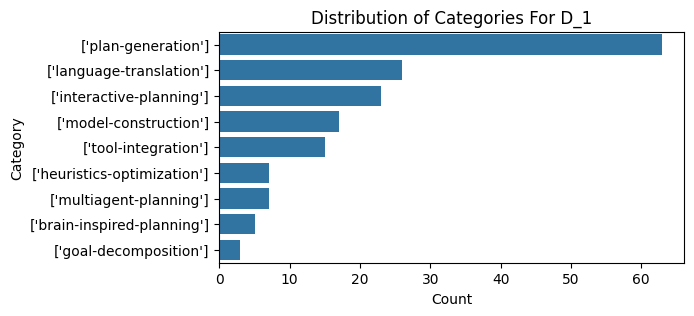

In [7]:
generate_distribution(df_existing, "category", "Distribution of Categories For D_1")

<br>


## Create Features


In [8]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_old = vectorizer.fit_transform(df_existing["text"])
X_new = vectorizer.transform(df_new["text"])

In [9]:
# Use LabelEncoder for single-label classification
le = LabelEncoder()
y_old = le.fit_transform(df_existing["category"])

<br>


## Train, Evaluate, and Test Model


In [10]:
np.random.seed(13)

In [11]:
# Convert sparse matrix to array for iterative stratification
X_old_array = X_old.toarray()

In [12]:
# Split old data into train and test sets using StratifiedShuffleSplit for single-label
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)

In [13]:
for train_idx, test_idx in sss.split(X_old_array, y_old):
    X_train = X_old[train_idx]
    X_test = X_old[test_idx]
    y_train = y_old[train_idx]
    y_test = y_old[test_idx]

In [14]:
# Print some information about the split
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (132, 3370)
Test set shape: (34, 3370)


In [15]:
# Print distribution information
def print_label_distribution(y, set_name):
    labels, counts = np.unique(y, return_counts=True)
    print(f"\nLabel distribution in {set_name}:")
    for label, count in zip(le.inverse_transform(labels), counts):
        if count > 0:  # Only print categories that appear
            print(f"{label}: {count}")


print_label_distribution(y_train, "training set")
print_label_distribution(y_test, "test set")


Label distribution in training set:
['brain-inspired-planning']: 4
['goal-decomposition']: 2
['heuristics-optimization']: 6
['interactive-planning']: 18
['language-translation']: 21
['model-construction']: 13
['multiagent-planning']: 6
['plan-generation']: 50
['tool-integration']: 12

Label distribution in test set:
['brain-inspired-planning']: 1
['goal-decomposition']: 1
['heuristics-optimization']: 1
['interactive-planning']: 5
['language-translation']: 5
['model-construction']: 4
['multiagent-planning']: 1
['plan-generation']: 13
['tool-integration']: 3


In [16]:
# For traditional ML models:
models = {
    "dt": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "rf": RandomForestClassifier(
        n_estimators=100, class_weight="balanced_subsample", random_state=42
    ),
    "svm": LinearSVC(class_weight="balanced", random_state=42, max_iter=1000),
}

In [17]:
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    results[model_name] = {
        "test_report": classification_report(
            y_test, y_pred_test, target_names=le.classes_, zero_division=0
        ),
        "predictions": model.predict(X_new),
    }

Training dt...
Training rf...
Training svm...
Training svm...


/Users/nitingupta/miniconda3/envs/aiisc_litcat/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [18]:
# Print results for the old dataset
for model_name, model_data in results.items():
    print(f"\nResults for {model_name} on test set:")
    print(model_data["test_report"])


Results for dt on test set:
                             precision    recall  f1-score   support

['brain-inspired-planning']       0.00      0.00      0.00         1
     ['goal-decomposition']       0.00      0.00      0.00         1
['heuristics-optimization']       0.00      0.00      0.00         1
   ['interactive-planning']       0.29      0.40      0.33         5
   ['language-translation']       0.25      0.20      0.22         5
     ['model-construction']       1.00      0.25      0.40         4
    ['multiagent-planning']       1.00      1.00      1.00         1
        ['plan-generation']       0.38      0.38      0.38        13
       ['tool-integration']       0.40      0.67      0.50         3

                   accuracy                           0.35        34
                  macro avg       0.37      0.32      0.32        34
               weighted avg       0.41      0.35      0.35        34


Results for rf on test set:
                             precision    

In [19]:
# Convert predictions back to categories for all classifiers
for classifier, data in results.items():
    df_new[f"{classifier}_predicted"] = le.inverse_transform(data["predictions"])
    print(f"\nPredicted category distribution for {classifier}:")
    print(df_new[f"{classifier}_predicted"].value_counts())


Predicted category distribution for dt:
dt_predicted
['plan-generation']            17
['interactive-planning']        8
['tool-integration']            7
['multiagent-planning']         4
['language-translation']        4
['heuristics-optimization']     3
['brain-inspired-planning']     2
['model-construction']          2
['goal-decomposition']          2
Name: count, dtype: int64

Predicted category distribution for rf:
rf_predicted
['plan-generation']         45
['interactive-planning']     1
['tool-integration']         1
['language-translation']     1
['goal-decomposition']       1
Name: count, dtype: int64

Predicted category distribution for svm:
svm_predicted
['plan-generation']            26
['interactive-planning']        6
['language-translation']        5
['tool-integration']            4
['multiagent-planning']         4
['heuristics-optimization']     2
['model-construction']          1
['goal-decomposition']          1
Name: count, dtype: int64


In [20]:
df_new.columns

Index(['Title', 'Authors', 'Published Date', 'Abstract', 'URL', 'Categories',
       'text', 'dt_predicted', 'rf_predicted', 'svm_predicted'],
      dtype='object')

In [21]:
# Save results to a new CSV for predictions
df_new.to_csv("../outputs/ml_single_label_predictions_2025.csv", index=False)